In [1]:
# Import necessary packages

import numpy as np
import scipy as sp
import skimage as sk

import copy

from statistics import mode

import matplotlib.pyplot as plt

import matplotlib.path as Path
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import minimum_filter, median_filter

import os

import importlib

from PIL import Image

from colour import Color

%matplotlib notebook

In [2]:
import pld
importlib.reload(pld)

<module 'pld' from '/Users/erinfleck/Desktop/python/phase/pld.py'>

In [3]:
here = '/Users/erinfleck/Desktop/research/STO Data Sets n 6/' # Directory to image
name = '06_3.6Mx_1x1us_4096px_50umC2_CL130mm_600pAscreen_1.tif' # Image name

filename = here + name

In [4]:
im=Image.open(filename) # Open image
im=np.array(im) # Convert to array
im=im/float(im.max()) # Normalize image intensity
im=im[0:np.min(im.shape), 0:np.min(im.shape)] # Make square

<IPython.core.display.Javascript object>


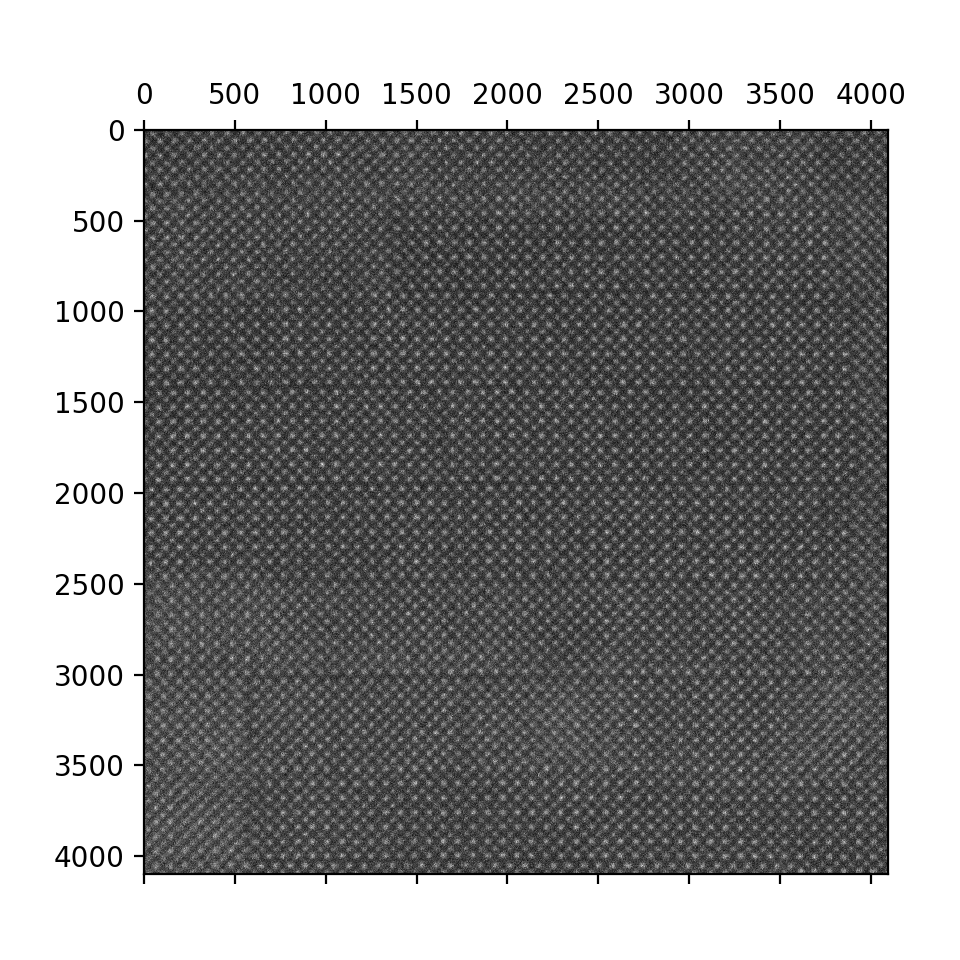

In [5]:
plt.matshow(im, cmap='gray') # Show image

## Fourier Peaks

In [6]:
T=pld.ReciprocalIndex(im)

In [7]:
T._initSuperlatticePeaks('q_x','q_y', 'q_arb') 

### Superlattice peaks

Assume x refers to in-plane, and y refers to out-of-plane.

#### x-direction

In [8]:
# In this demo notebook, the peak position is at x = 2048.0582818762864
# y = 2149.301159137688. You can practice finding this peak yourself or 
# just click randomly on any one of the bright spots and then simply run the cell below  
# T.q_x.refinePeakPositions containing the coordinates.

<IPython.core.display.Javascript object>


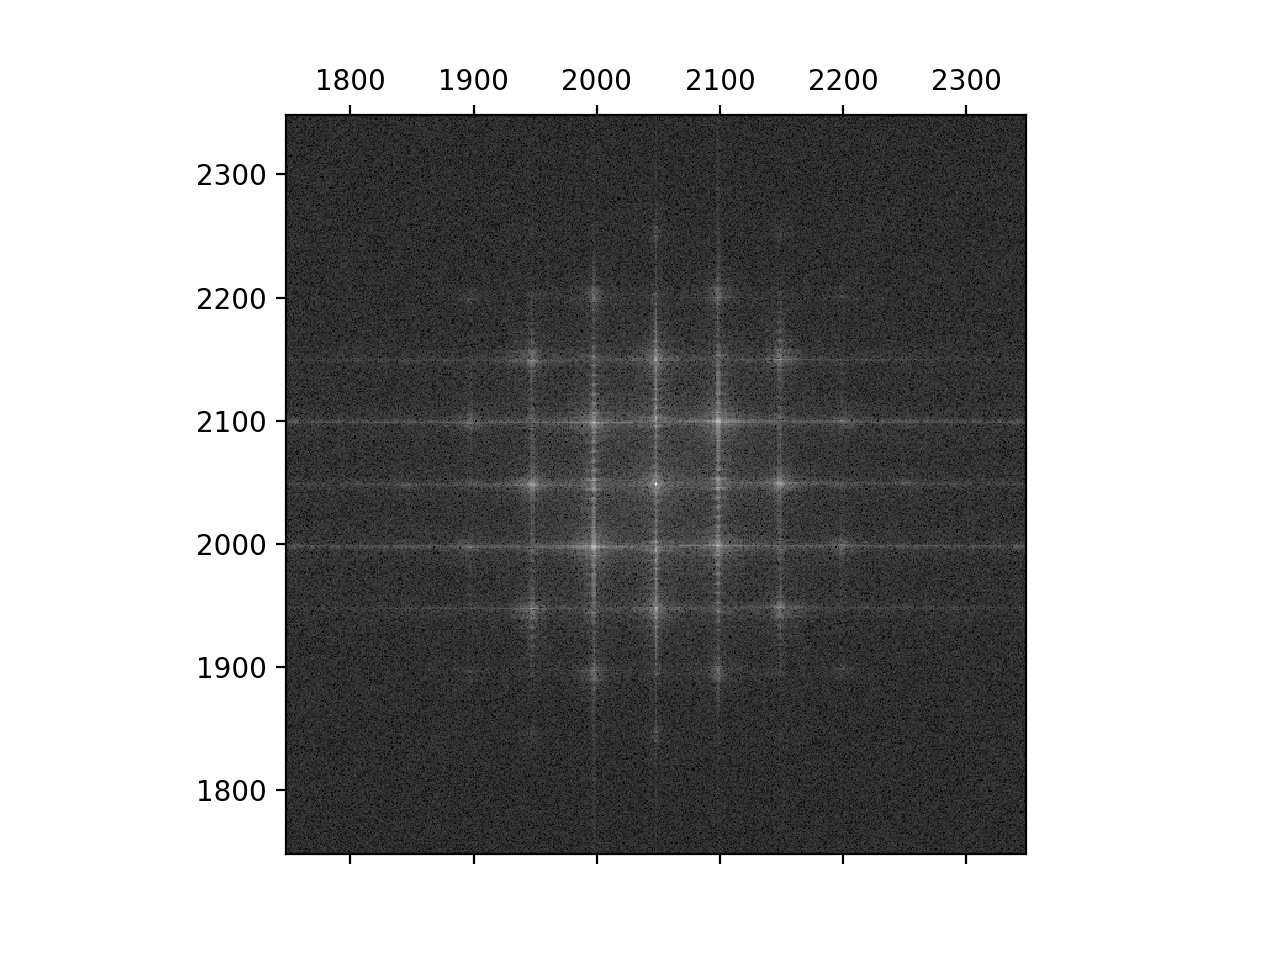

In [9]:
# Click the 020 Bragg spot

T.q_x._clickPeakPosition(zoom=300) # Larger zoom argument -> zoom out; smaller argument -> zoom in


try:
    plt.plot(T.q_x.x,T.q_x.y,'ro') # Plot peaks if any already selectred
except AttributeError:
    pass




In [10]:
T.q_x._appendPeakPosition()  

In [11]:
T.q_x.refinePeakPositions(crop_window=17, track_window=15)

In [12]:
T.q_x.x[-1] = 2048.0582818762864
T.q_x.y[-1] = 2149.301159137688

In [13]:
alpha = np.arctan(((im.shape[1]/2)-T.q_x.x[-1])/((im.shape[0]/2)-T.q_x.y[-1])) # Defines angle of sample

### Peak positions

<IPython.core.display.Javascript object>


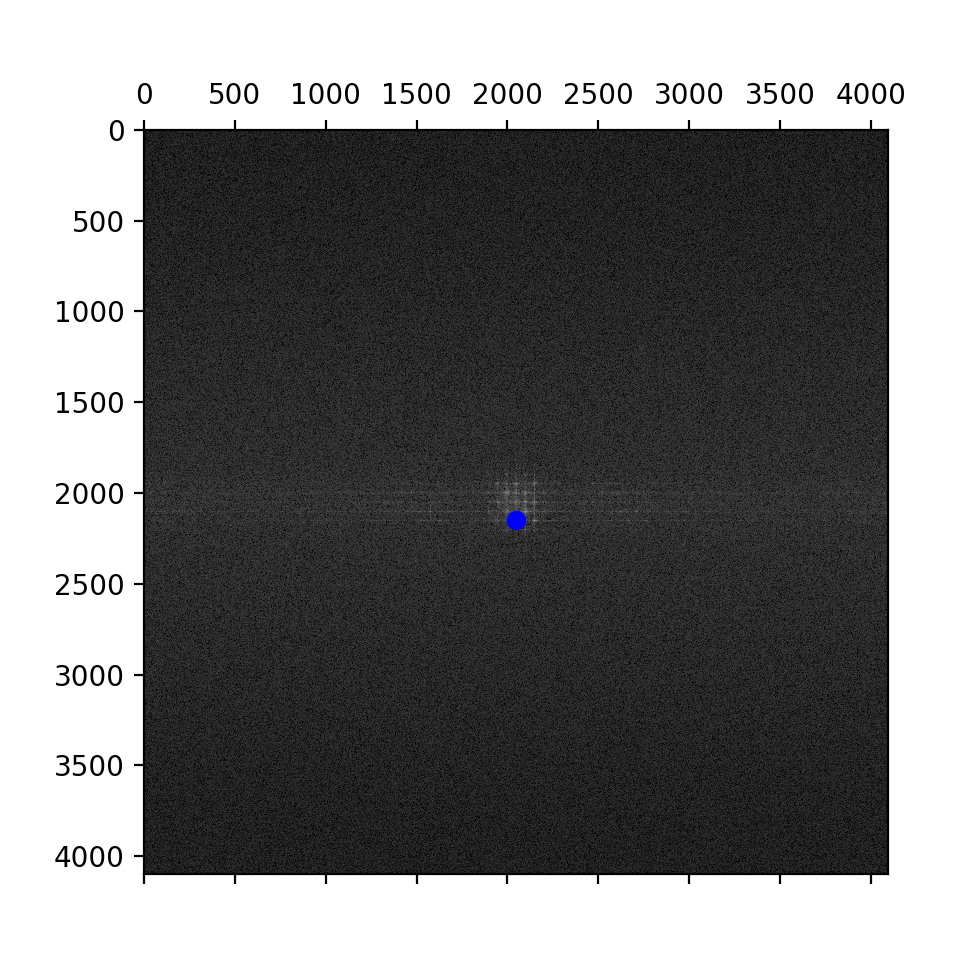

In [14]:
plt.matshow(T.logfft, cmap='gray')
plt.plot(T.q_x.x[-1],T.q_x.y[-1],'bo') # Plot peaks

## Phase

### x-direction

In [15]:
sigma=16. # Mask size


# Mask size defines real-space coarsening through the below formula
# coarsening (angstrom) = lattice spacing (angstrom) * distance from center of fft to 010/100 bragg spot / mask size

# Coarsening around 12 A works for high-resolution images, but as field of view becomes larger you will need lower resolution

#If you select too small of a mask size, it may not cover the entire bragg spot and you will not get any sort of useful data
# If the mask is too large, then you will get an image that is too high resolution and includes a lot of noise 

In [16]:
i,label=-1,'020' #Sets fourier point and assigned it a label that can be used in filenaming 
r_dummy= T.Fourier.fourierFilter(T.q_x.x[i],T.q_x.y[i], sigma=sigma)
r=T.Fourier.phaseLockin(T.q_x.x[i],T.q_x.y[i], sigma_x=sigma, sigma_y=sigma)
phase_q_x=(r[0])%(2*np.pi)

In [17]:
T.Fourier.phase=(T.Fourier.phase-np.pi/2.)%(2.*np.pi) # Generates phase map

In [18]:
kx=T.q_x.x[i]-T.im.shape[0]/2. # Generates wavevectors
ky=T.q_x.y[i]-T.im.shape[1]/2.

In [19]:
T.Fourier.get_eps(ky,kx, phase_shift=np.pi/17.) # Generates strain map

In [20]:
eps_xc,eps_xs = T.Fourier.eps_compression.copy(), T.Fourier.eps_shear.copy()

<IPython.core.display.Javascript object>


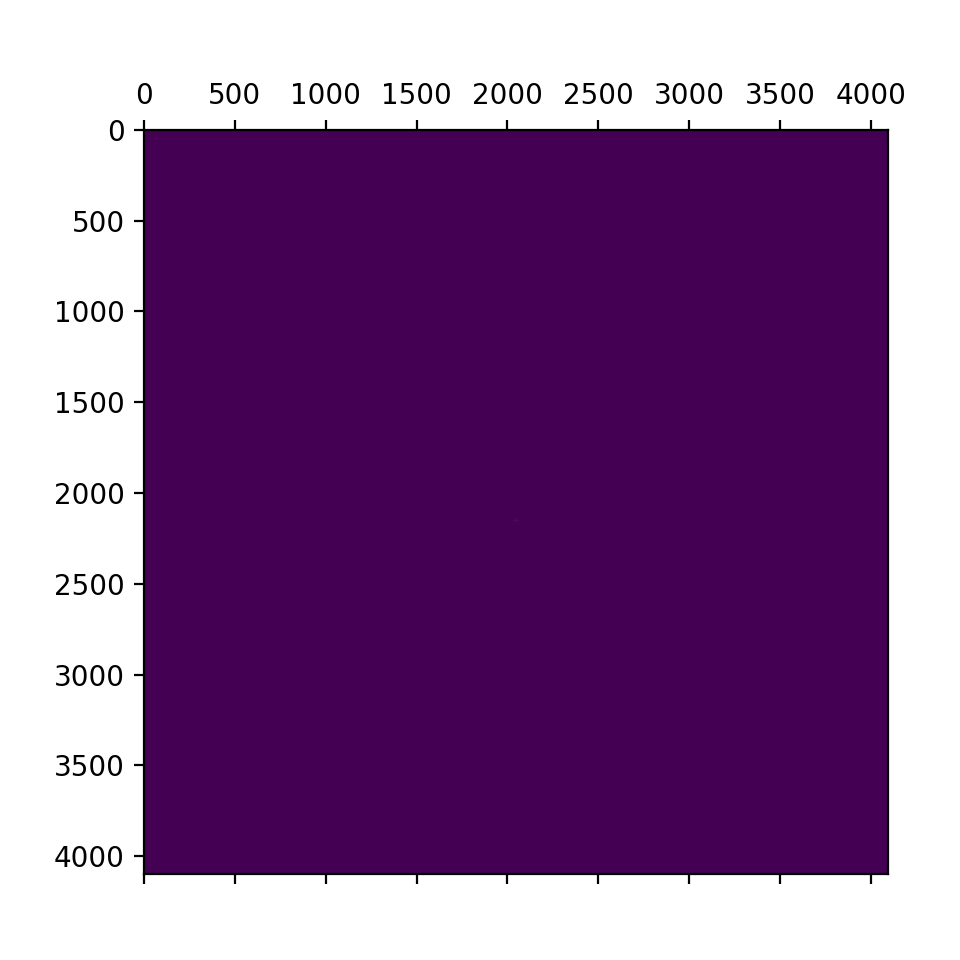

In [21]:
plt.matshow(np.abs(r_dummy[1])) # Shows Fourier component

# To zoom in on masked peak, uncomment following lines.

# plt.xlim((T.q_x.x[i]-im.shape[0]/20, T.q_x.x[i]+im.shape[0]/20))
# plt.ylim((T.q_x.y[i]-im.shape[1]/20, T.q_x.y[i]+im.shape[1]/20))

### Strain

<IPython.core.display.Javascript object>


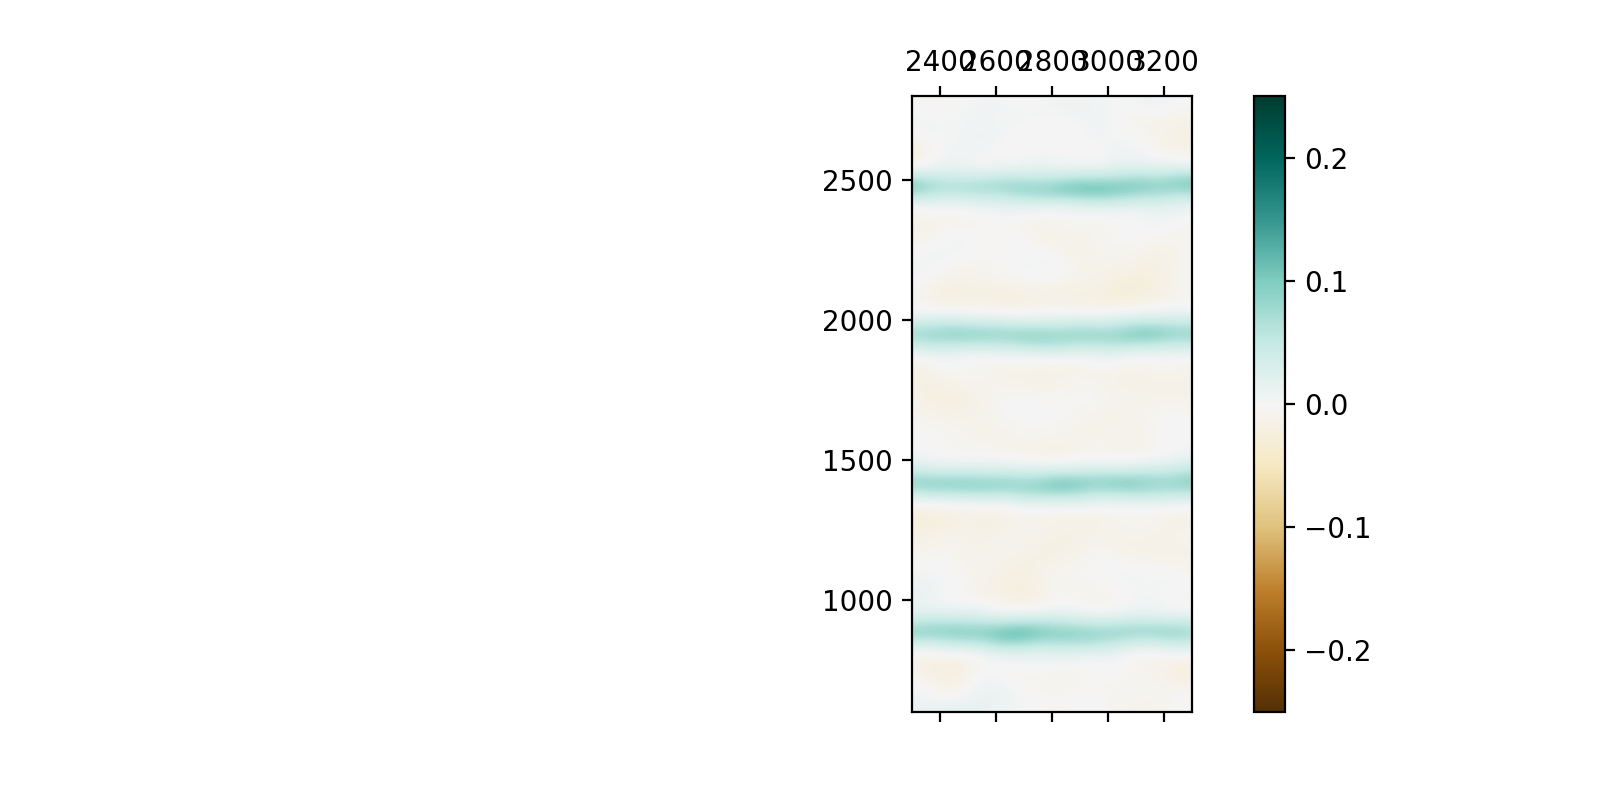

(2300.0, 3300.0, 600.0, 2800.0)

In [22]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)


c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=5), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 1)


plt.xlim(2300, 3300)
plt.ylim(600, 2800)
plt.colorbar(c_im0)

plt.axis("on")


In [23]:
threshold = 0.03 # The weakest strain that you want to consider as a boundary. 
                 # I recommend finding a solid boundary, and then finding the strain on the edge of it.
                 # This may take some playing around with. 
        
threshold_og = threshold

<IPython.core.display.Javascript object>


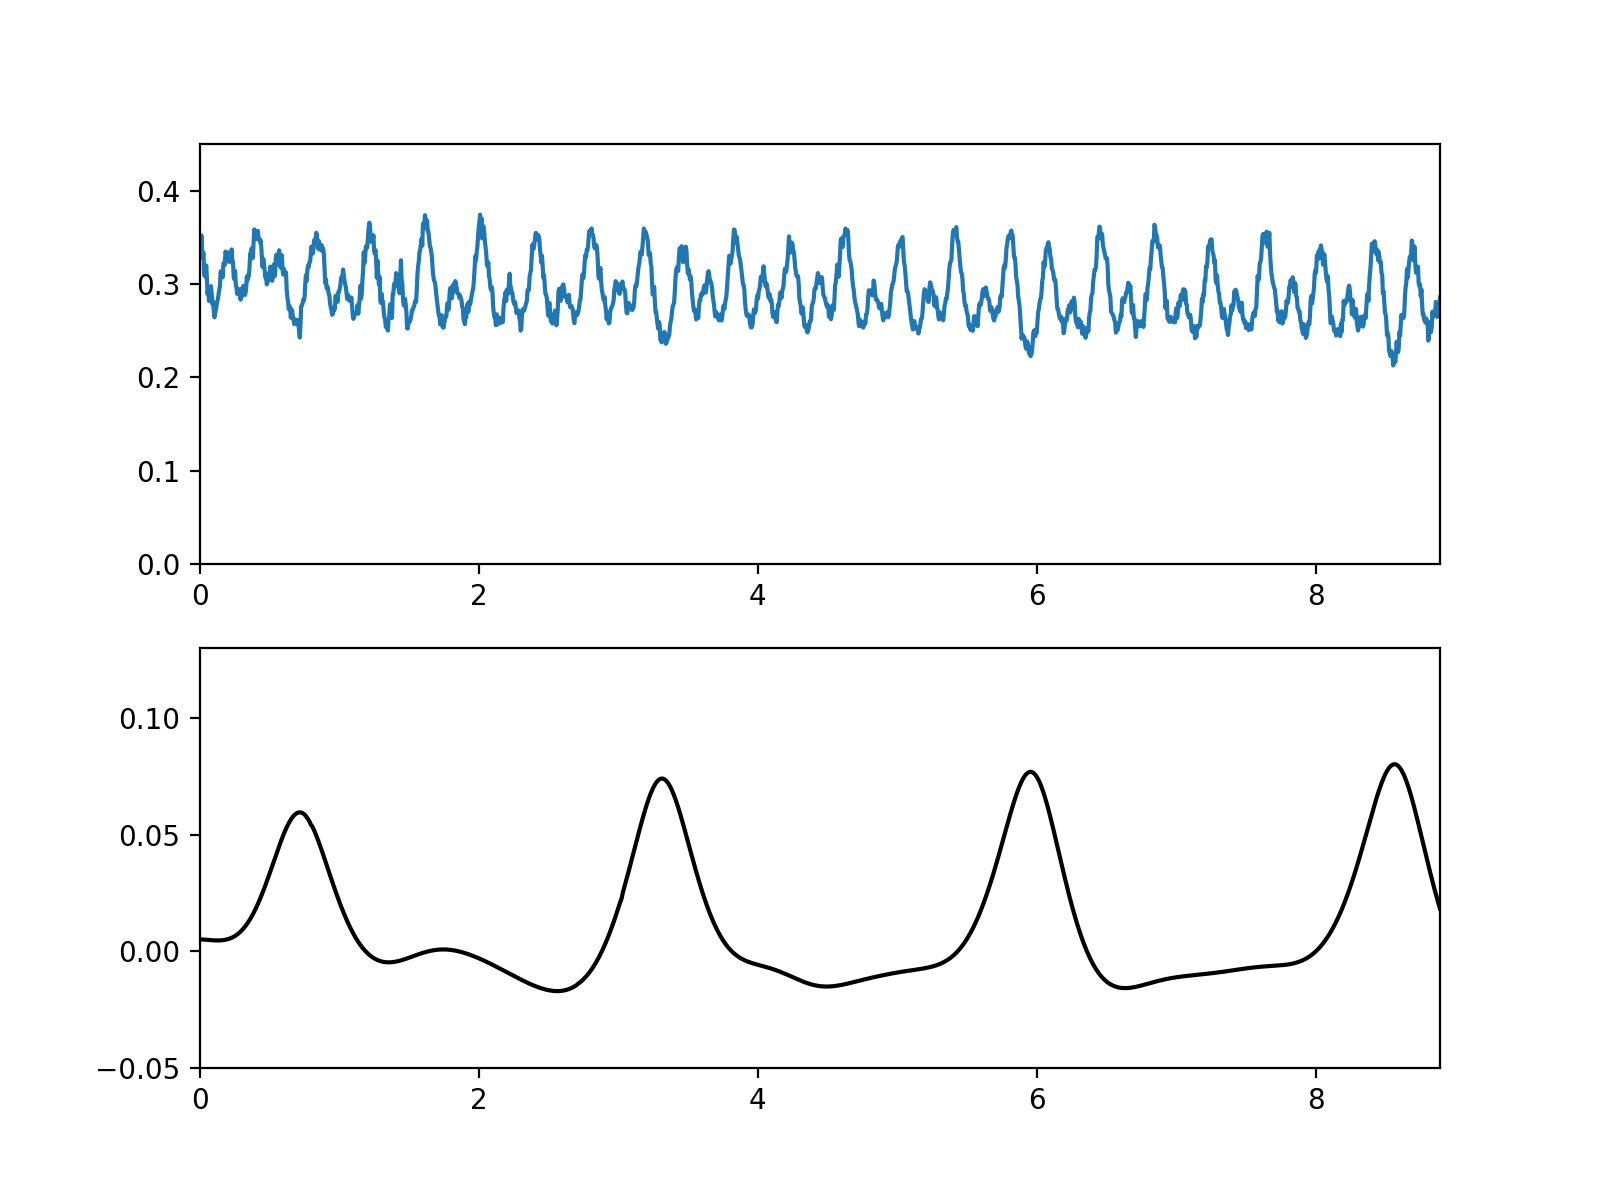

In [24]:
# To generate line cuts of image intensity qnd strain map

px_scale = np.sqrt((T.q_x.x[-1]-im.shape[1]/2)**2+(T.q_x.y[-1]-im.shape[0]/2)**2)/(2*im.shape[0]) # Defines conversion factor for pixels to local n

x0 = 2504
y0 = 2620
y1 = 819
x1 = int((y1-y0)*np.tan(alpha)+x0)
z = sk.measure.profile_line(image = eps_xc, src = [y0, x0], dst = [y1, x1], linewidth = int(1/(px_scale))) # Takes integrated width line profile

fig, ax =plt.subplots(2, figsize=(8,6), sharex=False, sharey=False)


ang = []
axis = []
px_scale = np.sqrt((T.q_x.x[-1]-im.shape[1]/2)**2+(T.q_x.y[-1]-im.shape[0]/2)**2)/(2*im.shape[0])
for i in range(len(z)):
    ang.append(i*px_scale*3.99/10)
    axis.append(i)
    
ax[1].set_xlim(0,max(ang), 'k')
ax[1].set_ylim(-0.05, 0.13)

z1 = sk.measure.profile_line(image = T.im, src = [y0, x0], dst = [y1, x1], linewidth = int(1/(px_scale))) # Takes integrated width line profile
ax[0].plot(ang, z1)
ax[0].set_ylim(0, 0.45)
ax[0].set_xlim(0, max(ang))




ax[1].plot(ang, z, 'k')
ax[1].set_xticks([0.0, 2.0, 4.0, 6.0, 8.0])
ax[0].set_xticks([0.0, 2.0, 4.0, 6.0, 8.0])